In [1]:
import networkx as nx # version 2.2
import matplotlib.pyplot as plt
# plt.style.use('classic')
# %matplotlib inlin
import re
import cvxpy as cp
import operator #to sort elements in a list of tuples
import itertools
import math
import numpy as np
import os
import sys
import time
import random
import glob
from matplotlib.ticker import MultipleLocator


import Init_NetRate as Init
import cvxpy as cp
import Cascade_generation_functions_NetRate as Gen
import CVX_functions as cvx
import NetRate_ADMM_fcts as ADMM
import NetRate_SG_fcts as NetSG

import Init_NetInf
import Greedy_NetInf as Greed

In [2]:
def Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,A_hat,lower_bound):
    correct = 0
    nb_edges = 0
    top_acc = 0
    bot_acc = 0
    for i in range(0,G_true.number_of_nodes()):
        for j in range(0,G_true.number_of_nodes()):
            if A_hat[i,j] >lower_bound:
                nb_edges +=1
                bot_acc +=1
                if (i,j) in G_true.edges():
                    correct +=1
                    bot_acc+=1
                else :
                    top_acc+=1
            else :
                if (i,j) in G_true.edges():
                    top_acc +=1
                    bot_acc+=1
                
    precision = correct/nb_edges
    recall = correct/G_true.number_of_edges()
    accuracy = 1-(top_acc/bot_acc)
    mse = 0
    nb_correcte_edges=0
    for i in G_true.nodes():
        for j in G_true.nodes():
            if (i,j) in G_true.edges():
                try:
                    true_alpha = G_true.edges[(i,j)]["weight"][0]
                except TypeError:
                    true_alpha = G_true.edges[(i,j)]["weight"]
            else :
                true_alpha = 0
            approx_alpha = A_hat[i,j]
            mse += pow((true_alpha-approx_alpha),2) # mean square error
    try :
        mse = mse/(G_true.number_of_nodes()**2)
    except ZeroDivisionError:
        print ("There is no correct edge")
    return (precision,recall,accuracy,mse)

def Global_Precision_Recall_Accuracy_NetInf(G_true,G_max):
    correct = 0
    top_acc = 0
    bot_acc = 0
    nb_edges_G_max = G_max.number_of_edges()
    nb_edges_G_true = G_true.number_of_edges()
    for i in range(0,G_true.number_of_nodes()):
        for j in range(0,G_true.number_of_nodes()):
            if (i,j) in G_max.edges() :
                bot_acc +=1
                if(i,j) in G_true.edges() :
                    bot_acc +=1
                    correct+=1
                else :
                    top_acc +=1
            else :
                if (i,j) in G_true.edges():
                    top_acc +=1
                    bot_acc +=1
    precision = correct/nb_edges_G_max
    recall = correct/nb_edges_G_true
    accuracy = 1-top_acc/bot_acc
    return(precision,recall,accuracy)

def Write_info(file_path,time,algo_infos):
    precision,recall,accuracy,mse = algo_infos
    f = open(file_path,"w")
    f.write("General Infos\n")
    f.write("time needed : "+str(time)+" s\n")
    f.write("Accuracy of the algo : " +str(accuracy)+"\n")
    f.write("precision of the algo : "+str(precision)+"\n")
    f.write("recall of the algo : "+str(recall)+"\n")
    f.write("mean square error is : "+str(mse)+"\n")
    f.close()

# Parameters

In [6]:
'''
Global parameters for the cascade model and for all solving methods.
'''
window = 10
beta = 1 # used for the construction of the cascades, probability of the edge to transmit the infection
eps = 1e-64 #zero machine
alpha_min = 0.0005
alpha_max = 10 #bound alpha from above
alpha_init = 0.01 #initial value of the infectious rates
tol = 0.05 # value from which we decide that there exist an edge
more_infos_Netrate = True # If set to true computes the time,accuracy and mean square error at each iteration (solves down the overall computartion)
# can also be modified for each solver.

'''For stochastic block model'''
nb_communities = 10 #number of communities we want our graph to have
p_1 = 0.4 # proba that the edge connect two vertices in the same community
p_2 = 0.15 # proba that the edge connect two vertices in different communities


solvers = ["SGD","ADMM"] #List containing the solver that should be used. "NetInf","CVX","SGD","ADMM"
gen = "Erdos" # can either be "Erdos" or "Stochastic"
'''
NetRate with CVX
'''
more_infos_CVX = more_infos_Netrate

'''
NetRate with SGD parameters
'''
gamma_SGD = 0.0005
K = 30000 #number of itterations of SGD
more_infos_SGD = more_infos_Netrate

SGD_param = (alpha_init,alpha_max,K,gamma_SGD,alpha_min,window,tol,more_infos_SGD)

'''
Netrate with ADMM
'''
iter_ADMM = 50 #number of itteration for 1 node in the ADMM method. This is a parameter to tune
iter_GD_ADMM = 2000 #number of iterations of the gradient descent
gamma_ADMM = 0.00005 # Learning rate of the GD for alpha (maybe too small)
u = 4 # used for the gradient descent of rho and as a penalizer and the constrain
more_infos_ADMM = more_infos_Netrate 
line_search = True #Used line search in the first iteration of ADMM for each nodes to find the good learning rate for GD
param_ADMM = (alpha_init,alpha_max,window,iter_GD_ADMM,iter_ADMM,gamma_ADMM,u,eps,tol,more_infos_ADMM,line_search)

'''
NetInf paramters
'''
EPS = 1e-64 #zero machine
ALPHA = 1.0 #Incubation parameter (for exp and power law)
MODEL = 0 # 0 = exp law, 1 = power law (power law is not  implemented yet) When constructing the underlying network specify that we use the exponential law
MAX = sys.float_info.max #Max value of a float in python
#MIN = sys.float_info.min #Min value of a float in python
MIN = -MAX
#(works only if groundtruth is available)
#When set to True (especially boundOn) it slow down greatly the computation
compare_groud_truth = False # If set to True outputs some aditional information (precision and recall of the algo)
boundOn = False

greedy_global_param = (ALPHA,MODEL,MAX,MIN,EPS,compare_groud_truth,boundOn)


# Script solving the optimization problem and saving the results

In [7]:
graph_list = [(1000,1000,2000)] # list of the graph we want to generate. Each graph is represented by a triple (vertex,edges,nb_cascades)
for i in range(0,len(graph_list)) :
    (vertex,edge,cascades) = graph_list[i]
    
    '''
    Creation of folder where the infos will be saved
    '''
    if gen =="Stochastic":
        folder_name = "Simulation_"+str(vertex)+"V_"+str(edge)+"E_"+str(cascades)+"C_SBM"
    else :
        folder_name = "Simulation_"+str(vertex)+"V_"+str(edge)+"E_"+str(cascades)+"C"
    try:
        os.mkdir(folder_name)
    except FileExistsError :
        print("folder exists already")
    folder_path = "./"+folder_name    
    graph_file_name = "Graph_true_"+str(vertex)+"V_"+str(edge)+"E.txt"
    cascade_file_name = "Cascades_"+str(vertex)+"V_"+str(edge)+"E.txt"
    graph_path = os.path.join(folder_path+"/"+graph_file_name)
    cascade_path = os.path.join(folder_path+"/"+cascade_file_name)
    
    '''
    Generation of ground truh and cascades. Save them in the above defined folder.
    '''
    if gen == "Erdos" :
        G_true = Gen.Generate_random_graph(vertex,edge)
    if gen == "Stochastic" :
        print("plop")
        G_true = Gen.Genrate_Stochastic_block_model_graph((vertex,edge,nb_communities),(p_1,p_2)) # Generates the underlying network
    Cascades = Gen.Generate_all_cascades(G_true,-cascades,window,MODEL,beta) # generates the cascades
    Gen.Save_cascade_to_file(cascade_path,Cascades,G_true)
    Gen.Save_graph_to_file(graph_path,G_true)
    del Cascades
    
    '''
    Infer the underlying network based on the choosen solver(s)
    '''
    if "NetInf" in solvers :
        print("**********NetInf**********")
        G_star_NF,DAG_Tree_c_dic_NF,cascades_per_edge_dic_NF,edge_gain_dic_NF = Init_NetInf.Init(cascade_path,EPS,MAX)
        nb_max_edge = int(1*G_true.number_of_edges()) #fix a number of edges we want to recover 
        ground_truth = G_true
        t_s = time.time()
        G_max,precision,recall,edge_info = Greed.GreedyOpt(nb_max_edge,DAG_Tree_c_dic_NF,cascades_per_edge_dic_NF,edge_gain_dic_NF,G_star_NF,True,greedy_global_param)
        t_f = time.time()
        algo_info = Global_Precision_Recall_Accuracy_NetInf(G_true,G_max)
        algo_info = algo_info+(-15,)
        time_algo = t_f-t_s
        general_info_path = os.path.join(folder_path+"/General_Infos_NetInf.txt")
        Write_info(general_info_path,time_algo,algo_info)
        print(time_algo)
        del G_star_NF,DAG_Tree_c_dic_NF,cascades_per_edge_dic_NF,edge_gain_dic_NF
    
    '''
    Initialization for NetRate
    '''
    G_star,C_dic = Init.Init(cascade_path)
    N = G_true.number_of_nodes()
    
    if "CVX" in solvers :
        print("**********NetRate_CVX**********")
        A_list,nb_c_per_node = cvx.Create_matrices(N,C_dic,window)
        t_s = time.time()
        A_hat_CVX,final_obj_value,acc_mse_time_CVX = cvx.Infer_Network_edges(N,A_list,nb_c_per_node,C_dic,more_infos_CVX)
        t_f = time.time()
        time_algo_CVX=t_f-t_s
        algo_infos_CVX = Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,A_hat_CVX,tol)
        np.save(os.path.join(folder_path+"/"+"alpha_CVX"),A_hat_CVX)
        general_info_path_CVX = os.path.join(folder_path+"/General_Infos_CVX.txt")
        Write_info(general_info_path_CVX,time_algo_CVX,algo_infos_CVX)
        print(time_algo_CVX)
    
    if "SGD" in solvers :
        print("**********NetRate_SGD**********")
        t_s = time.time()
        A_hat_SG,acc_mse_time_SGD = NetSG.Netrate_SGD(G_true,C_dic,N,SGD_param)
        t_f = time.time()
        time_algo_SGD = t_f-t_s      
        algo_infos_SGD = Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,A_hat_SG,tol)
        np.save(os.path.join(folder_path+"/"+"alpha_SGD"),A_hat_SG)
        general_info_path_SGD = os.path.join(folder_path+"/General_Infos_SGD.txt")
        Write_info(general_info_path_SGD,time_algo_SGD,algo_infos_SGD)
        print(time_algo_SGD)
    
    if "ADMM" in solvers :
        print("**********NetRate_ADMM**********")
        t_s = time.time()
        A_hat_ADMM,obj_per_iter_per_node_ADMM,acc_mse_time_ADMM = ADMM.NetRate_ADMM(G_true,C_dic,N,param_ADMM)
        t_f = time.time()
        time_algo_ADMM = t_f-t_s
        algo_infos_ADMM = Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,A_hat_ADMM,0.05)
        np.save(os.path.join(folder_path+"/alpha_ADMM"),A_hat_ADMM)
        general_info_path_ADMM = os.path.join(folder_path+"/General_Infos_ADMM.txt")
        Write_info(general_info_path_ADMM,time_algo_ADMM,algo_infos_ADMM)
        print(time_algo_ADMM)
        
        
    '''
    Plots for each graph solved. The plots are stored in the corresponding folder
    '''    
    time_ADMM = []
    acc_ADMM = []
    mse_ADMM = []
    time_SGD = []
    acc_SGD = []
    mse_SGD = []
    time_CVX = []
    acc_CVX = []
    mse_CVX = []
    
    if more_infos_ADMM and "ADMM" in solvers :
        for bla in acc_mse_time_ADMM :
            acc_ADMM.append(bla[0])
            mse_ADMM.append(bla[1])
            time_ADMM.append(bla[2])

        time_cum_ADMM = np.cumsum(time_ADMM)

    if more_infos_SGD and "SGD" in solvers :        
        for plop in acc_mse_time_SGD :
            acc_SGD.append(plop[0])
            mse_SGD.append(plop[1])
            time_SGD.append(plop[2])

        time_cum_SGD = np.cumsum(time_SGD)

    if more_infos_CVX and "CVX" in solvers :        
        for plop in acc_mse_time_CVX:
            acc_CVX.append(plop[0])
            mse_CVX.append(plop[1])
            time_CVX.append(plop[2])
        time_cum_CVX = np.cumsum(time_CVX)

    if more_infos_CVX or more_infos_SGD or more_infos_ADMM :
        
        plt.figure(1)
        if more_infos_ADMM:
            plt.plot(time_cum_ADMM,acc_ADMM,label = 'ADMM')
        if more_infos_SGD:
            plt.plot(time_cum_SGD,acc_SGD,label = "SGD")
        if more_infos_CVX:
            plt.plot(time_cum_CVX,acc_CVX,label = "CVX")
        plt.xlabel("running time (s)")
        plt.ylabel("Accuracy")
        plt.legend(loc = 'lower right')
        plt.title("G=(%i,%i) with |C| = %i" %(vertex,edge,cascades))
        plt.savefig(os.path.join(folder_path+"/ACC_TIME"))
        plt.show()


        plt.figure(2)
        if more_infos_ADMM:
            plt.plot(time_cum_ADMM,mse_ADMM,label = "ADMM")
        if more_infos_SGD:
            plt.plot(time_cum_SGD,mse_SGD,label = "SGD")
        if more_infos_CVX:
            plt.plot(time_cum_CVX,mse_CVX,label = "CVX")
        plt.ylabel("Mean square error (MSE)")
        plt.xlabel("running time (s)")
        plt.title("G=(%i,%i) with |C| = %i" %(vertex,edge,cascades))
        plt.legend(loc = "best")
        plt.savefig(os.path.join(folder_path+"/MSE_TIME"))
        plt.show()
    del G_star,C_dic

folder exists already
All nodes were read
**********NetRate_SGD**********


KeyboardInterrupt: 

In [ ]:
time_ADMM = []
acc_ADMM = []
mse_ADMM = []
time_SGD = []
acc_SGD = []
mse_SGD = []
time_CVX = []
acc_CVX = []
mse_CVX = []
if more_infos_ADMM and "ADMM" in solvers :
    for bla in acc_mse_time_ADMM :
        acc_ADMM.append(bla[0])
        mse_ADMM.append(bla[1])
        time_ADMM.append(bla[2])
        
    time_cum_ADMM = np.cumsum(time_ADMM)

if more_infos_SGD and "SGD" in solvers :        
    for plop in acc_mse_time_SGD :
        acc_SGD.append(plop[0])
        mse_SGD.append(plop[1])
        time_SGD.append(plop[2])
        
    time_cum_SGD = np.cumsum(time_SGD)

if more_infos_CVX and "CVX" in solvers :        
    for plop in acc_mse_time_CVX:
        acc_CVX.append(plop[0])
        mse_CVX.append(plop[1])
        time_CVX.append(plop[2])
    time_cum_CVX = np.cumsum(time_CVX)
        
if more_infos_CVX or more_infos_ADMM or more_infos_ADMM :
    plt.figure(1)
    plt.plot(time_cum_ADMM,acc_ADMM,label = 'ADMM')
    plt.plot(time_cum_SGD,acc_SGD,label = "SGD")
    plt.plot(time_cum_CVX,acc_CVX,label = "CVX")
    plt.xlabel("running time (s)")
    plt.ylabel("Accuracy")
    plt.legend(loc = 'lower right')
    plt.title("G=(%i,%i) with |C| = %i" %(vertex,edge,cascades))
    plt.savefig(os.path.join(folder_path+"/ACC_TIME"))
    plt.show()


    plt.figure(2)
    plt.plot(time_cum_ADMM,mse_ADMM,label = "ADMM")
    plt.plot(time_cum_SGD,mse_SGD,label = "SGD")
    plt.plot(time_cum_CVX,mse_CVX,label = "CVX")
    plt.ylabel("Mean square error (MSE)")
    plt.xlabel("running time (s)")
    plt.title("G=(%i,%i) with |C| = %i" %(vertex,edge,cascades))
    plt.legend(loc = "best")
    plt.savefig(os.path.join(folder_path+"/MSE_TIME"))
    plt.show()

In [ ]:
'''
Go into the directories to load the wanted files (like true network or alpha etc..)
'''

for plop in os.listdir(os.getcwd()):
    if "Simulation_1024V_2048E_3000C_SBM" in plop :
        path = os.path.join(os.getcwd()+"/"+plop)
        print(path)
        for files in glob.glob(path+"/*") :
            if "Graph_" in files :
                G_true = Init.Load_ground_truth(files)
        for files in glob.glob(path+"/*.npy") :
            print("plop")
            if "ADMM" in files :
                alpha_ADMM = np.load(files)
                algos_infos = Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,alpha_ADMM,0.05)
                print("ADMM_MSE : " ,algos_infos[-1])
            if "SGD" in files :
                alpha_SGD = np.load(files)
                algos_infos = Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,alpha_SGD,0.05)
                print("SGD_MSE : " ,algos_infos[-1])
            if "CVX" in files :
                alpha_CVX = np.load(files)
                algos_infos = Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,alpha_CVX,0.05)
                print("CVX_MSE : ", algos_infos[-1])

# Individual functions

In [4]:
# G_true = Init.Load_ground_truth(network_file_name)
# G_star, DAG_C_dic = Init.Init(cascade_file_name)
# N = G_true.number_of_nodes()
cascade_file = "Cascade_gen.txt"
graph_true_file ="run_for_the_plot.txt"
G_true = Gen.Generate_random_graph(10,40)
Cascades = Gen.Generate_all_cascades(G_true,-300,window,MODEL,beta)
Gen.Save_cascade_to_file(cascade_file,Cascades,G_true)
Gen.Save_graph_to_file(graph_true_file,G_true)
G_star,C_dic = Init.Init(cascade_file)
N = G_true.number_of_nodes()


# G_star_NF,DAG_Tree_c_dic_NF,cascades_per_edge_dic_NF,edge_gain_dic_NF = Init_NetInf.Init(cascade_file,EPS,MAX)

All nodes were read


In [ ]:
nb_max_edge = int(1*G_true.number_of_edges()) #fix a number of edges we want to recover (here 90%)
ground_truth = G_true
t_s = time.time()
G_max,precision,recall,edge_info = Greed.GreedyOpt(nb_max_edge,DAG_Tree_c_dic_NF,cascades_per_edge_dic_NF,edge_gain_dic_NF,G_star_NF,True,greedy_global_param)
t_f = time.time()
Global_Precision_Recall_Accuracy_NetInf(G_true,G_max)
print ("Netinf took : ",t_f-t_s)

In [ ]:
A_list,nb_c_per_node = cvx.Create_matrices(N,C_dic,window)
t_s = time.time()
alpha_mat,final_obj_value,acc_mse_time_CVX = cvx.Infer_Network_edges(N,A_list,nb_c_per_node,C_dic,more_infos_CVX)
t_f = time.time()
print("NetRate CVX took : ",t_f-t_s)
Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,alpha_mat,0.05)
np.save("alpha_CVX",alpha_mat)

In [ ]:
t_s = time.time()
A_hat_SG,acc_mse_time_SGD = NetSG.Netrate_SGD(G_true,C_dic,N,SGD_param)
t_f = time.time()
print("NetRate SG took ",t_f-t_s)
Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,A_hat_SG,0.05)
np.save("alpha_SGD",A_hat_SG)

In [ ]:
Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,A_hat_SG,0.05)

In [5]:
t_s = time.time()
A_hat_ADMM,obj_per_iter_per_node_ADMM,acc_mse_time_ADMM,Lag = ADMM.NetRate_ADMM(G_true,C_dic,N,param_ADMM,True)
t_f = time.time()
print("ADMM took ",t_f-t_s)
print(Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,A_hat_ADMM,0.05))
np.save("alpha_ADMM",A_hat_ADMM)

t [[0.00015134]]
t [[0.00021765]]
t [[0.00022452]]
t [[0.00054167]]
t [[0.00046055]]
t [[0.00017597]]
t [[0.00028178]]
t [[0.0002567]]
t [[0.00046395]]
t [[0.00035086]]
ADMM took  15.494201421737671
(1.0, 0.925, 0.961038961038961, 0.005766764703724513)


8
[array([15.8706576]), array([2.74210828]), array([0.05655482])]
231.92113181405819


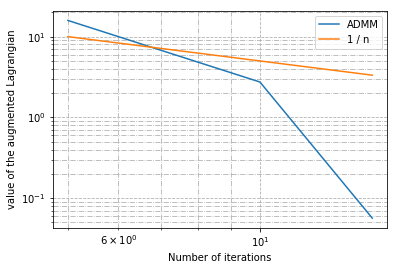

In [39]:
# rand_node = np.random.choice(N)
rand_node = 8
print(rand_node)
# iter_node_i_obj = obj_per_iter_per_node_ADMM[rand_node]
iter_node_i_Lag = Lag[rand_node]
true_obj_i = ADMM.Compute_true_objective_value_per_node(G_true,C_dic,window,rand_node)
iter_node_i_Lag_shifted =   [  max(x-true_obj_i,0) for x in iter_node_i_Lag[0:3]]
mesh_size = int(iter_ADMM/len(iter_node_i_Lag))
print(iter_node_i_Lag_shifted)
print(true_obj_i)
x_data = [x*mesh_size for x in range(1,len(iter_node_i_Lag_shifted)+1)]
y_n_data = [1/x*10 for x in range(1,len(x_data)+1)]
plt.figure()
plt.loglog(x_data,iter_node_i_Lag_shifted,label="ADMM")
plt.loglog(x_data,y_n_data,label = "1 / n")
plt.grid(True,which = 'major',linestyle ='--')
plt.grid(True,which = 'minor',linestyle="-.")
plt.legend(loc="best")
plt.xlabel("Number of iterations")
plt.ylabel("value of the augmented Lagrangian")
plt.savefig("convergenceplot")
plt.show()


In [ ]:
x_data = [x*mesh_size for x in range(1,len(iter_node_i_Lag_shifted)+1)]
y_n_data = [1/x*10 for x in range(1,len(x_data)+1)]
fig,ax = plt.subplots()

ax.loglog(x_data,iter_node_i_Lag_shifted,label="ADMM")
ax.loglog(x_data,y_n_data, label ="1/n")
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.grid(True,which = 'major',linewidth=3)
plt.grid(True,which = 'minor',linestyle='--')

plt.legend(loc = "best")
plt.xlabel("Number of iterations")
plt.ylabel("Value of the augmented Lagrangian")
plt.show()

In [ ]:
x_data = [x*mesh_size for x in range(1,len(iter_node_i_Lag_shifted)+1)]
y_n_data = [1/x*10 for x in range(1,len(x_data)+1)]
plt.figure()
plt.loglog(x_data,iter_node_i_Lag_shifted)
plt.loglog(x_data,y_n_data)
plt.show()

In [ ]:
len(list(G_true.predecessors(9)))

In [ ]:
print(Global_Precision_Recall_Accuracy_MSE_NetRate(G_true,A_hat_ADMM,0.05))
print(true_obj_i)
print(iter_node_i_Lag)